In [1]:
import matplotlib

%matplotlib notebook
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm_notebook
from sklearn.svm import SVR

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
from mayavi import mlab

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
features_filename = '39-features-v2.xlsx'

In [3]:
df = pd.read_excel(features_filename, index_col=0)

# Categorize cmap all subjects

In [5]:
df.head()

,all_all_max_amplitude,all_all_max_power,all_all_max_power_freq,all_alpha_max_amplitude,all_alpha_max_power,all_alpha_max_power_freq,all_beta_max_power,all_beta_max_power_freq,all_delta_max_power,all_delta_max_power_freq,...,wavelet_central_max_power_freq,wavelet_central_max_power_time,wavelet_ltm1_max_power_at_freq,wavelet_ltm1_max_power_at_time,wavelet_ltm1_max_power_freq,wavelet_ltm1_max_power_time,wavelet_rtm1_max_power_at_freq,wavelet_rtm1_max_power_at_time,wavelet_rtm1_max_power_freq,wavelet_rtm1_max_power_time
0,0.000002,2.777808e-16,36,0.000002,1.656928e-16,10,6.341239e-17,26,5.535620e-17,4,...,1699.758956,389.247039,9.290681,-0.203200,795.413564,391.136163,0.976562,-0.260847,920.688314,205.866166
1,0.000002,7.045166e-16,10,0.000002,7.045166e-16,10,3.202701e-16,22,1.251420e-16,2,...,1350.207889,412.348892,11.048543,-0.074716,2749.205329,869.753544,15.625000,-0.341944,874.440057,279.965552
2,0.000002,4.643096e-16,24,0.000002,1.054613e-16,10,4.643096e-16,24,3.785974e-16,4,...,1504.189000,407.994715,2.129898,-0.179751,2413.468286,1359.271661,17.039183,-0.176331,822.499312,317.586076
3,0.000002,6.469294e-16,18,0.000002,6.144056e-16,10,6.469294e-16,18,3.054810e-16,2,...,722.309329,221.358686,18.581361,-0.500718,1147.498869,447.783394,1.953125,-0.117707,846.045450,335.391806
4,0.000002,8.671570e-16,34,0.000002,3.254531e-16,8,7.122134e-16,26,2.245107e-16,2,...,7217.637690,1182.716816,7.812500,-0.102074,1469.422729,698.547856,1.161335,-0.206620,2639.615189,646.149552


In [27]:
p1 = np.percentile(df['mep_category_cmap'], 33.33)
p2 = np.percentile(df['mep_category_cmap'], 66.66)
cat = np.ones(len(df['mep_category_cmap'])) * ((df['mep_category_cmap'] >= p1) & (df['mep_category_cmap'] < p2))
cat = 2 * (df['mep_category_cmap'] >= p2) * np.ones(len(df['mep_category_cmap'])) + cat
df['mep_category_cmap_across_subjects'] = cat

# Histogram

In [28]:
mep_metric = 'mep_category_cmap_across_subjects'

In [29]:
df.head()

,all_all_max_amplitude,all_all_max_power,all_all_max_power_freq,all_alpha_max_amplitude,all_alpha_max_power,all_alpha_max_power_freq,all_beta_max_power,all_beta_max_power_freq,all_delta_max_power,all_delta_max_power_freq,...,wavelet_central_max_power_time,wavelet_ltm1_max_power_at_freq,wavelet_ltm1_max_power_at_time,wavelet_ltm1_max_power_freq,wavelet_ltm1_max_power_time,wavelet_rtm1_max_power_at_freq,wavelet_rtm1_max_power_at_time,wavelet_rtm1_max_power_freq,wavelet_rtm1_max_power_time,mep_category_cmap_across_subjects
0,0.000002,2.777808e-16,36,0.000002,1.656928e-16,10,6.341239e-17,26,5.535620e-17,4,...,389.247039,9.290681,-0.203200,795.413564,391.136163,0.976562,-0.260847,920.688314,205.866166,2.0
1,0.000002,7.045166e-16,10,0.000002,7.045166e-16,10,3.202701e-16,22,1.251420e-16,2,...,412.348892,11.048543,-0.074716,2749.205329,869.753544,15.625000,-0.341944,874.440057,279.965552,1.0
2,0.000002,4.643096e-16,24,0.000002,1.054613e-16,10,4.643096e-16,24,3.785974e-16,4,...,407.994715,2.129898,-0.179751,2413.468286,1359.271661,17.039183,-0.176331,822.499312,317.586076,1.0
3,0.000002,6.469294e-16,18,0.000002,6.144056e-16,10,6.469294e-16,18,3.054810e-16,2,...,221.358686,18.581361,-0.500718,1147.498869,447.783394,1.953125,-0.117707,846.045450,335.391806,1.0
4,0.000002,8.671570e-16,34,0.000002,3.254531e-16,8,7.122134e-16,26,2.245107e-16,2,...,1182.716816,7.812500,-0.102074,1469.422729,698.547856,1.161335,-0.206620,2639.615189,646.149552,1.0


In [30]:
channel = 'ltm1'

In [31]:
x = df['wavelet_' + channel + '_max_power_at_freq']
y = df['wavelet_' + channel + '_max_power_freq']
z = df[mep_metric]

In [32]:
print(x.shape)
print(y.shape)
print(z.shape)

(1400,)
(1400,)
(1400,)


In [33]:
import seaborn as sns

In [34]:
df2 = df
df2['power_group'] = pd.cut(df2['wavelet_'+channel+'_max_power_freq'], np.linspace(0, 14000, 100))
df2['power_group'] = df2['power_group'].astype(str)
df2 = df2.pivot_table(mep_metric, index='power_group', columns='wavelet_' + channel + '_max_power_at_freq', aggfunc=np.max)

In [35]:
df2.head()

wavelet_ltm1_max_power_at_freq,2.129897915361832,2.32267014648969,2.532889755177753,2.762135864009951,3.012130518374884,3.284751622084823,3.582047043768247,3.90625,4.259795830723664,4.645340292979379,...,10.13155902071101,11.04854345603981,12.04852207349954,13.13900648833929,14.32818817507299,15.625,17.03918332289465,18.58136117191752,20.26311804142203,31.25
power_group,,,,,,,,,,,,,,,,,,,,,
"(0.0, 141.414]",2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(10040.404, 10181.818]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(10888.889, 11030.303]",NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(1131.313, 1272.727]",2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN
"(11737.374, 11878.788]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df2.shape

(56, 28)

<IPython.core.display.Javascript object>


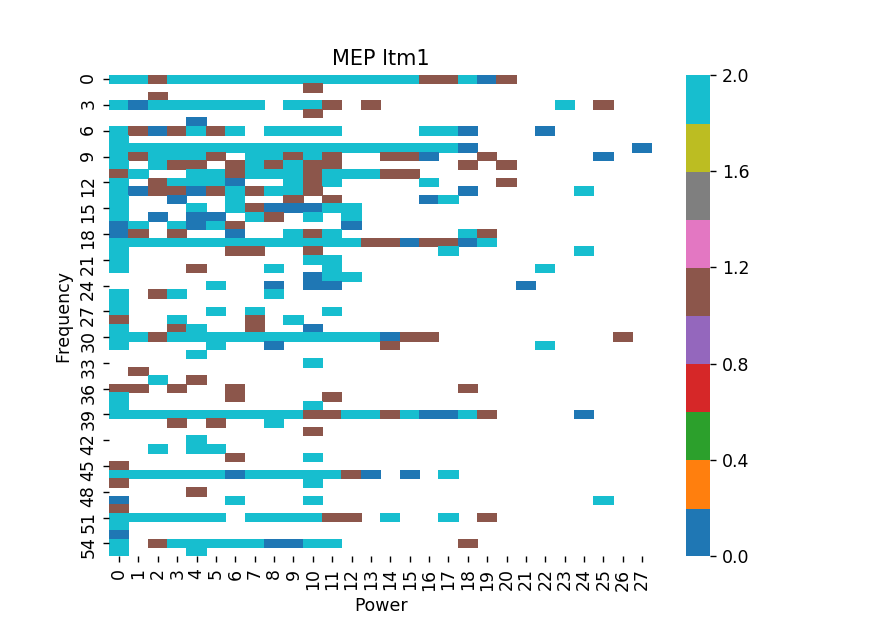

In [37]:
plt.figure(figsize=(7,5))
ax = sns.heatmap(df2.values, cmap='tab10', robust=True)
ax.set_xlabel('Power')
ax.set_ylabel('Frequency')
ax.set_title('MEP ' + channel)
plt.show()

In [38]:
df2 = df[df[mep_metric] == 0]
df2['power_group'] = pd.cut(df2['wavelet_'+channel+'_max_power_freq'], np.linspace(0, 14000, 100))
df2['power_group_left'] = df2['power_group'].apply(lambda x: x.left)
df2 = df2.groupby(['power_group_left', 'wavelet_'+channel+'_max_power_at_freq']).count()
df2 = df2.pivot_table(mep_metric, index='power_group_left', columns='wavelet_' + channel + '_max_power_at_freq', aggfunc='sum')
df2.tail()

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


wavelet_ltm1_max_power_at_freq,2.129897915361832,2.32267014648969,2.532889755177753,2.762135864009951,3.012130518374884,3.284751622084823,3.582047043768247,3.90625,4.259795830723664,4.645340292979379,...,7.8125,8.519591661447327,9.290680585958759,10.13155902071101,11.04854345603981,13.13900648833929,14.32818817507299,17.03918332289465,18.58136117191752,31.25
power_group_left,,,,,,,,,,,,,,,,,,,,,
13292.929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13434.343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13575.758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13717.172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13858.586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
def plot_heatmap(df2, title):
    title = title + ' - ' + str(df2.shape[0]) + ' MEPs'
    df2['power_group'] = pd.cut(df2['wavelet_'+channel+'_max_power_freq'], np.linspace(0, 14000, 100))
    df2['power_group_left'] = df2['power_group'].apply(lambda x: x.left)
    df2 = df2.groupby(['power_group_left', 'wavelet_'+channel+'_max_power_at_freq']).count()
    df2 = df2.pivot_table(mep_metric, index='power_group_left', columns='wavelet_' + channel + '_max_power_at_freq', aggfunc='sum', fill_value=0, dropna=False)
    df2 = df2.sort_index(axis=1)
    df2 = df2.sort_index(axis=0)
    
    plt.figure(figsize=(9,8))
    ax = sns.heatmap(df2.values, cmap='viridis', robust=True, xticklabels=df2.columns, yticklabels=df2.index)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Power')
    ax.set_title(title)
    plt.show()

In [50]:
df[df[mep_metric] == 0].head()

,all_all_max_amplitude,all_all_max_power,all_all_max_power_freq,all_alpha_max_amplitude,all_alpha_max_power,all_alpha_max_power_freq,all_beta_max_power,all_beta_max_power_freq,all_delta_max_power,all_delta_max_power_freq,...,wavelet_ltm1_max_power_at_freq,wavelet_ltm1_max_power_at_time,wavelet_ltm1_max_power_freq,wavelet_ltm1_max_power_time,wavelet_rtm1_max_power_at_freq,wavelet_rtm1_max_power_at_time,wavelet_rtm1_max_power_freq,wavelet_rtm1_max_power_time,mep_category_cmap_across_subjects,power_group
39,0.000005,9.662689e-15,8,0.000005,9.662689e-15,8,7.113279e-15,18,8.363639e-16,2,...,3.582047,-0.271595,2039.143261,532.374297,1.266445,-0.329242,153450.746872,26854.319967,0.0,"(1979.798, 2121.212]"
44,0.000010,7.057952e-15,22,0.000010,1.876682e-15,16,7.057952e-15,22,1.944966e-15,2,...,2.532890,-0.235932,2487.714339,708.897728,0.976562,-0.027328,279967.705441,24627.845814,0.0,"(2404.04, 2545.455]"
0,0.000002,7.467177e-16,34,0.000002,6.502057e-16,16,6.502057e-16,16,1.419444e-16,0,...,3.012131,-0.336082,1860.488319,565.312645,0.976562,-0.155324,1342.248544,352.116572,0.0,"(1838.384, 1979.798]"
1,0.000002,7.148515e-16,12,0.000002,7.148515e-16,12,3.410910e-16,20,2.064318e-16,4,...,4.259796,-0.314098,2354.144647,439.619263,4.645340,-0.300907,1077.134960,460.468228,0.0,"(2262.626, 2404.04]"
2,0.000003,9.054660e-16,10,0.000003,9.054660e-16,10,8.225252e-16,20,5.198504e-16,4,...,3.284752,-0.287717,2409.251063,924.111637,1.161335,-0.283320,6373.552870,1205.618895,0.0,"(2404.04, 2545.455]"


In [51]:
from itertools import product

In [83]:
df4 = pd.DataFrame({"group":[1,1,1 ,2,2],
                   "cat": ['a', 'b', 'c', 'a', 'c'] ,
                   "value": range(5),
                   "value2": np.array(range(5))* 2})
df4

,group,cat,value,value2
0,1,a,0,0
1,1,b,1,2
2,1,c,2,4
3,2,a,3,6
4,2,c,4,8


In [85]:
dfo = pd.DataFrame(list(product(df4['group'].unique(), df4['cat'].unique())), columns=['group', 'cat'])
dfo

,group,cat
0,1,a
1,1,b
2,1,c
3,2,a
4,2,b
5,2,c


In [86]:
dfo.merge(df4, how='left').fillna(0)

,group,cat,value,value2
0,1,a,0.0,0.0
1,1,b,1.0,2.0
2,1,c,2.0,4.0
3,2,a,3.0,6.0
4,2,b,0.0,0.0
5,2,c,4.0,8.0


In [99]:
def plot_heatmap2(df2, title, df_all):
    title = title + ' - ' + str(df2.shape[0]) + ' MEPs'
    df2['power_group'] = pd.cut(df2['wavelet_'+channel+'_max_power_freq'], np.linspace(0, 14000, 100))
    df2['power_group_left'] = df2['power_group'].apply(lambda x: x.left)
    
    all_power_group = pd.cut(df_all['wavelet_'+channel+'_max_power_freq'], np.linspace(0, 14000, 100))
    all_power_group = all_power_group.apply(lambda x: x.left)
    
    df2 = df2.groupby(['power_group_left', 'wavelet_'+channel+'_max_power_at_freq']).count()
    df2 = df2.reset_index()
    df3 = pd.DataFrame(list(product(all_power_group.unique(), df_all['wavelet_'+channel+'_max_power_at_freq'].unique())), columns=['power_group_left', 'wavelet_'+channel+'_max_power_at_freq'])
    # df3 = pd.DataFrame(list(product(df2['power_group_left'].unique(), df2['wavelet_'+channel+'_max_power_at_freq'].unique())), columns=['power_group_left', 'wavelet_'+channel+'_max_power_at_freq'])
    df3 = df3.merge(df2, how='left').fillna(0)
    # print(df3.shape)
    df3 = df3.pivot_table(mep_metric, index='power_group_left', columns='wavelet_' + channel + '_max_power_at_freq', aggfunc='sum')
    df3 = df3.sort_index(axis=1)
    df3 = df3.sort_index(axis=0)
    
    plt.figure(figsize=(9,8))
    ax = sns.heatmap(df3.values, cmap='viridis', robust=True, xticklabels=df3.columns, yticklabels=df3.index)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Power')
    ax.set_title(title)
    plt.show()

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


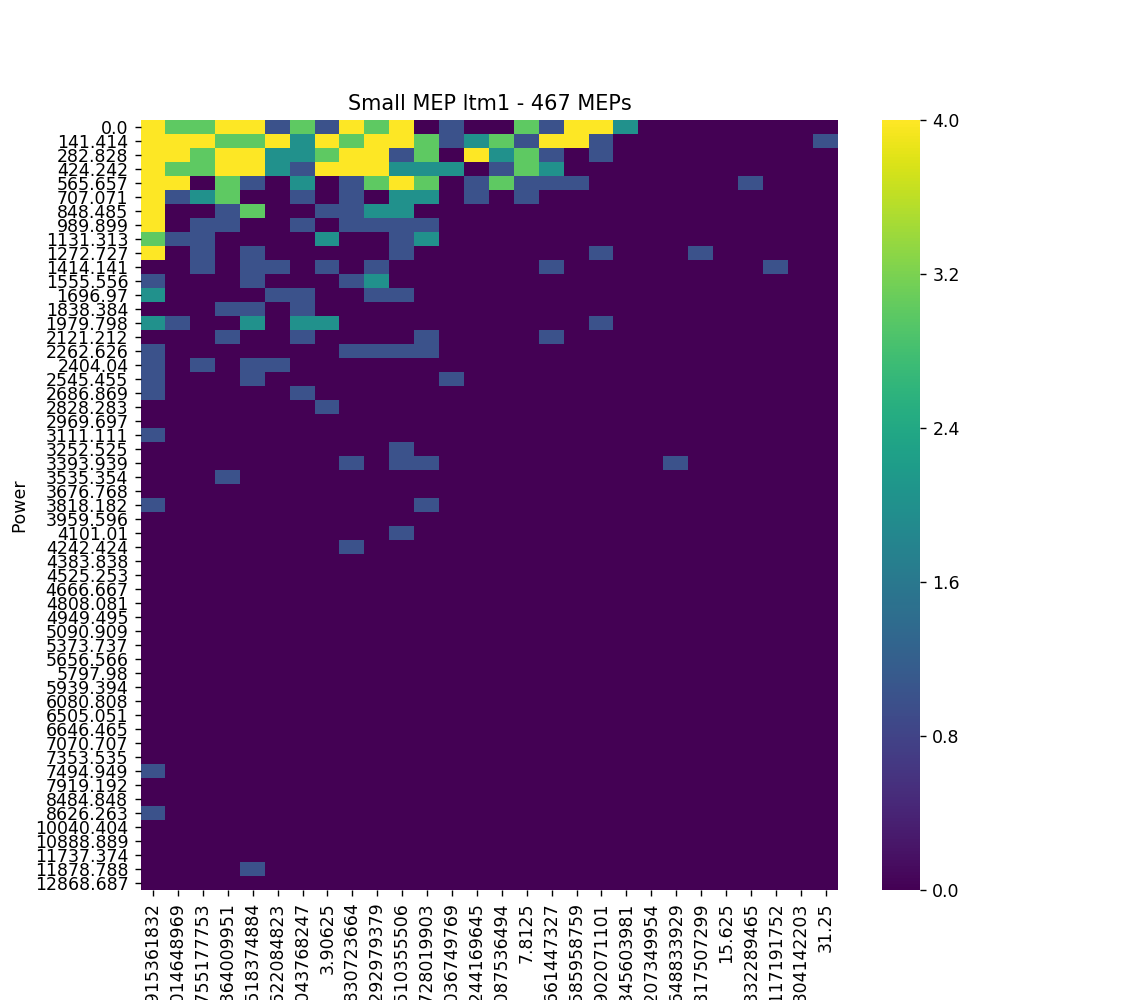

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


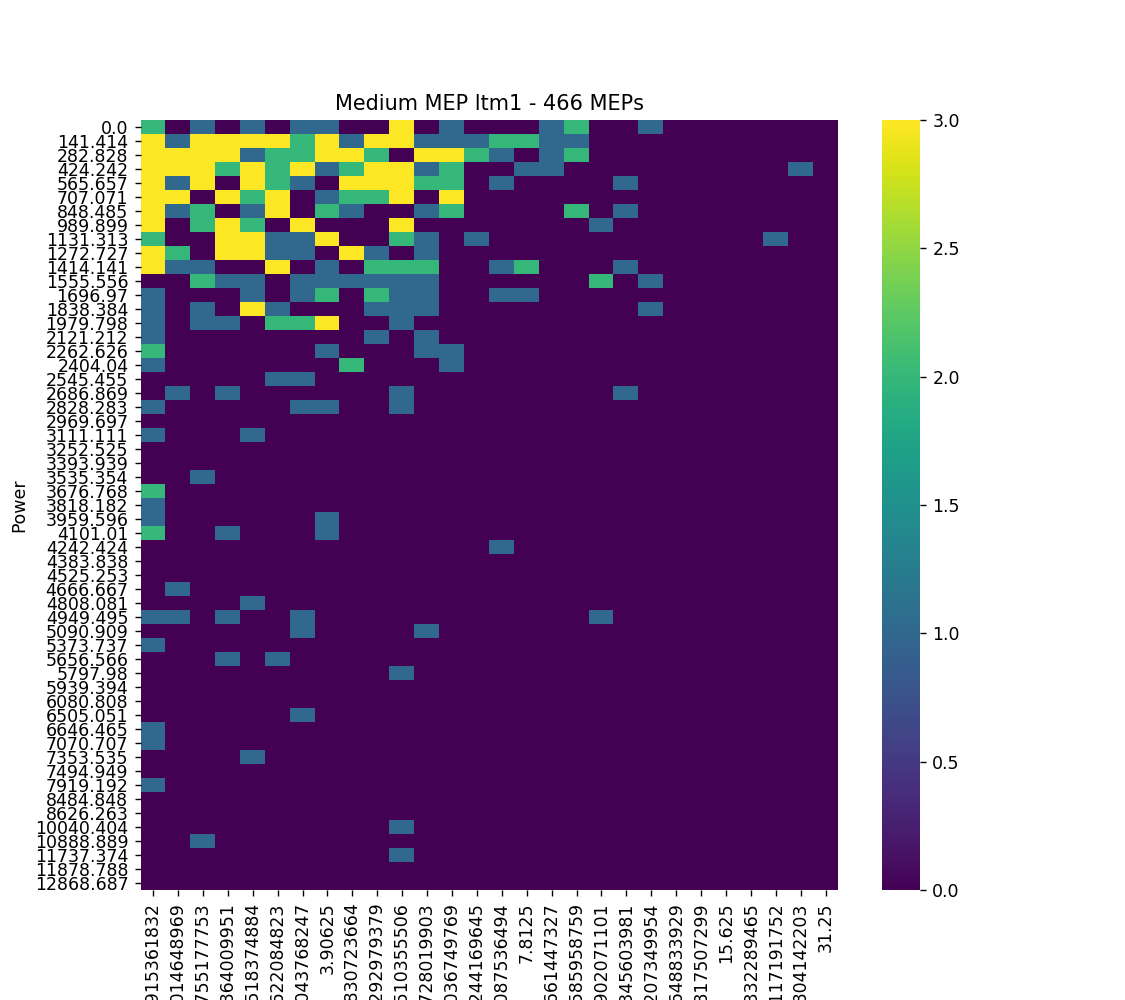

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


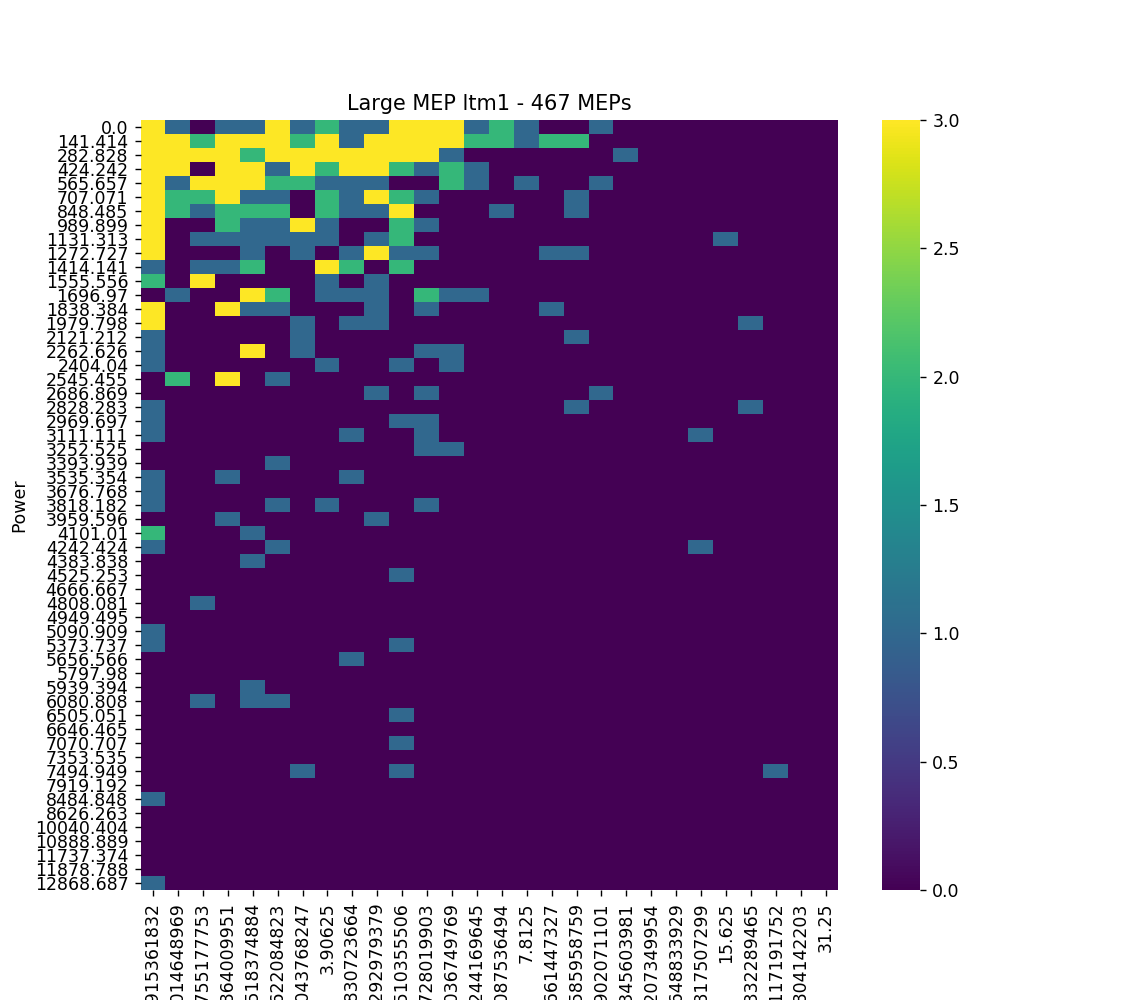

In [104]:
plot_heatmap2(df[df[mep_metric] == 0], 'Small MEP ' + channel, df)
plot_heatmap2(df[df[mep_metric] == 1], 'Medium MEP ' + channel, df)
plot_heatmap2(df[df[mep_metric] == 2], 'Large MEP ' + channel, df)